<a href="https://colab.research.google.com/github/ferranlarroyaub/RN-DL/blob/main/07MIAR_VC04_VC05_Deep_Vision_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 07MAIR - Redes Neuronales y Deep Learning
## VC04_V05: Deep Learning y Deep vision

In [24]:
# SOLO PARA USO EN GOOGLE COLABORATORY
# Para conectar el notebook con la cuenta de gdrive
from google.colab import drive
drive.mount('/content/drive/')

BASE_FOLDER = '/content/drive/My Drive/VIU/RN_DP/resources/' # Se debe garantizar que la carpeta docencia compartida se almacena en el directorio raíz de Google Drive. En caso contrario modificar este path

Mounted at /content/drive/


In [25]:
# Funciones base

import matplotlib.pyplot as plt
import numpy as np

def visualize_learning_curve(H):
  epochs = H.history["loss"]
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, len(epochs)), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, len(epochs)), H.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, len(epochs)), H.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, len(epochs)), H.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()

from sklearn.metrics import classification_report

def evaluate_model(model, x, y):
  print("[INFO]: Evaluando red neuronal...")
  predictions = model.predict(x, batch_size=128)
  print(classification_report(y, predictions.argmax(axis=1)))

## **INTRODUCCIÓN A LAS CONVOLUTIONAL NEURAL NETWORKS: MNIST DATASET**

#### **- Cargando el conjunto de datos**

In [26]:
# Cargar dataset de mnist
import tensorflow as tf

mnist = tf.keras.datasets.mnist  # Dataset digitos 0-9
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(X_train.shape)
print(y_train)

# Tipicamente si tenemos imagen RGB -->  (N, X, Y, C) con C=3 (si es gris C=1))
# La API de Keras asume que la dimensión del canal existe si o si. En este caso, debemos añadir dimension canal en el array

(60000, 28, 28)
[5 0 4 ... 5 6 8]


#### **- Acondicionando el conjunto de datos**

In [27]:
# Pre-procesado obligatorio cuando trabajo con redes neuronales
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.backend import expand_dims

# Normalizamos las imágenes entre [0, 255]
X_train_n, X_test_n = X_train/255., X_test/255.

# Particiones de los datos
X_train_n_tr, X_train_n_val, y_train_tr, y_train_val = train_test_split(
    X_train_n, y_train, test_size=0.1, random_state=42)

# Añadir dimensión de canal en el array
X_train_n_tr = np.expand_dims(X_train_n_tr, axis=-1)
X_train_n_val = np.expand_dims(X_train_n_val, axis=-1)
X_test_n = np.expand_dims(X_test_n, axis=-1)

# Nos aseguramos de que la dimensionalidad del array es la deseada
print(X_train_n_tr.shape)

(54000, 28, 28, 1)


#### **- Creando la topología de Red Neuronal (CNN) y entrenándola**

In [28]:
# Construccion de una red CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

# Red feedforward API secuencial
convnet = Sequential()

#-----------------
# BASE MODEL
#-----------------

# BM Bloque 1
convnet.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(28,28,1)))
convnet.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
convnet.add(layers.MaxPooling2D((2,2)))

# Que tamaño tiene el tensor de salida de aplicar el bloque 1 a una imagen de tamaño (1, 28, 28, 1)?
# (1, 14, 14, 32)  -->  14 porque hemos dividio por 2 por el max pooling y no hemos perdido info espacial por el 0-padding, y 32 salidas una por filtro

# Quantos parámetros entrenables tiene la capa layers.MaxPooling2D((2,2))?
# --> 0. No tiene, no es una capa densa, solo realiza una operación de máximo

# Quantos parámetros entrenables tiene la capa 1 del bloque 1? B1:C1
# --> 32*(1*(3x3)+1) = 320   (donde hay el 1, si fuese RGB tendriamos un 3)

# Quantos parámetros entrenables tiene la capa 2 del bloque 1? B1:C2
# --> 32*(32*(3x3)+1) = 9,248


# BM Bloque 2
convnet.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
convnet.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
convnet.add(layers.MaxPooling2D((2,2)))

# Quantos parámetros entrenables tiene la capa 1 del bloque 2? B2:C1
# --> 1 filtro de esa capa va a recibir --> 32 capas de activación
# --> Sobre cada uno de estos mapas de activación, va a aprender un kernel 3x3 --> 32 x 3 x 3
# --> Le añadimos un bias por cada suma --> (32x(3x3) + 1)
# --> Esto era para un filtro, pues debemos multiplicar por 64 filtros: 64 * (32*(3*3)+1) = 18,496


# BM Bloque 3
convnet.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
convnet.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
convnet.add(layers.MaxPooling2D((2,2)))


#-----------------
# TOP MODEL
#-----------------
convnet.add(layers.Flatten())
convnet.add(layers.Dense(64, activation='relu'))  # capa intermedia
convnet.add(layers.Dense(10, activation='softmax')) # multi-clase --> softmax con 10 clases


convnet.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 176,426 (689.16 KB)

 Trainable params: 176,426 (689.16 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Compilación

# El otro dia como pre-procesado, pasamos las etiquetas de categoricas a one-hot-encoding
# Etiquetas categorical (e.g. 3) --> Etiquetas OHE ([0,0,0,1,0,...])
# loss = categorical_crossentropy --> espera etiquetas en OHE
# loss = sparse_categorical_crossentropy --> etiquetas en formato categorico (sin pre-procesar a OHE)
# La sparse hace internamente el OHE, no tiene importancia

convnet.compile(optimizer ='adam',
               #loss = categorical_crossentropy  # Espera etiquetas en OHE
               loss = 'sparse_categorical_crossentropy',
               metrics = ['accuracy']
                )


In [9]:
# Entrenamiento
H = convnet.fit(X_train_n_tr, y_train_tr, epochs = 5, batch_size = 128,
                validation_data = (X_train_n_val, y_train_val))


# Epoch 1: accuracy 0.8368 y val_accuracy: 0.9853. Por qué?

# validación es muy pequeño 10% (y quizas no generaliza del todo), aunque no es el caso ya que ese 10% son 6000 muestras
# también podría ser por no hacer shuffle (barajar datos durante entrenamiento, para que en un batch haya muestras de distintas categorias)
# pero en este caso no afecta tanto el shuffle barajar los indices ya que al principio ya estan bastante barajados
# Lo que pasa realmente tienen que ver con la forma en que se calcula el accuracy y val accuracy
# Tenemos 422 iteracions = N/batch_size
# Iter. 1 --> pesos aleatorios
# Iter. 422 --> pesos algo mejores, más entrenamiento realizado -- AQUÍ SE CALCULA EL val_accuracy (después de las 422)
# Sin embargo, el accuracy se calcula como:
#   --> accuracy = MEAN(accuracy_Iter1, accuracy_Iter2....,accuracy_Iter422)
# normalmente solo pasa en la 1a epoca, como vemos. Asi que no hay que preocuparse


Epoch 1/5
 24/422 ━━━━━━━━━━━━━━━━━━━━ 3:09 477ms/step - accuracy: 0.2811 - loss: 2.0605

KeyboardInterrupt: 

#### **- Observando el proceso de entrenamiento para tomar decisiones**

In [ ]:
# Evaluación + Testeo

# Learning curves
visualize_learning_curve(H)

# Evaluando el modelo de predicción con las imágenes de test
evaluate_model(convnet, X_test_n, y_test)


## **¿POR QUE CONVOLUTIONAL NEURAL NETWORKS?: CIFAR DATASET**

#### **- Cargando el conjunto de datos y acondicionándolo**

In [30]:
# Importando el set de datos CIFAR10

# Data-set de objetos y animales, se trata de distingir los animales de los otros objetos
from tensorflow.keras.datasets import cifar10
labelNames = ['Avión', 'Automovil', 'Pájaro', 'Gato','Ciervo', 'Perro',
              ' Rana', 'Caballo', 'Barco','Camión']

# Cargamos los datos
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print(X_train.shape)
print(y_train)

# Normalizamos las imágenes entre [0, 255]
X_train_n, X_test_n = X_train/255., X_test/255.

# Particiones de los datos
X_train_n_tr, X_train_n_val, y_train_tr, y_train_val = train_test_split(
    X_train_n, y_train, test_size=0.1, random_state=42)

# 32x32 pixeles y 3 canales de entrada


(50000, 32, 32, 3)
[[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]


#### **- Inspeccionando el conjunto de datos**

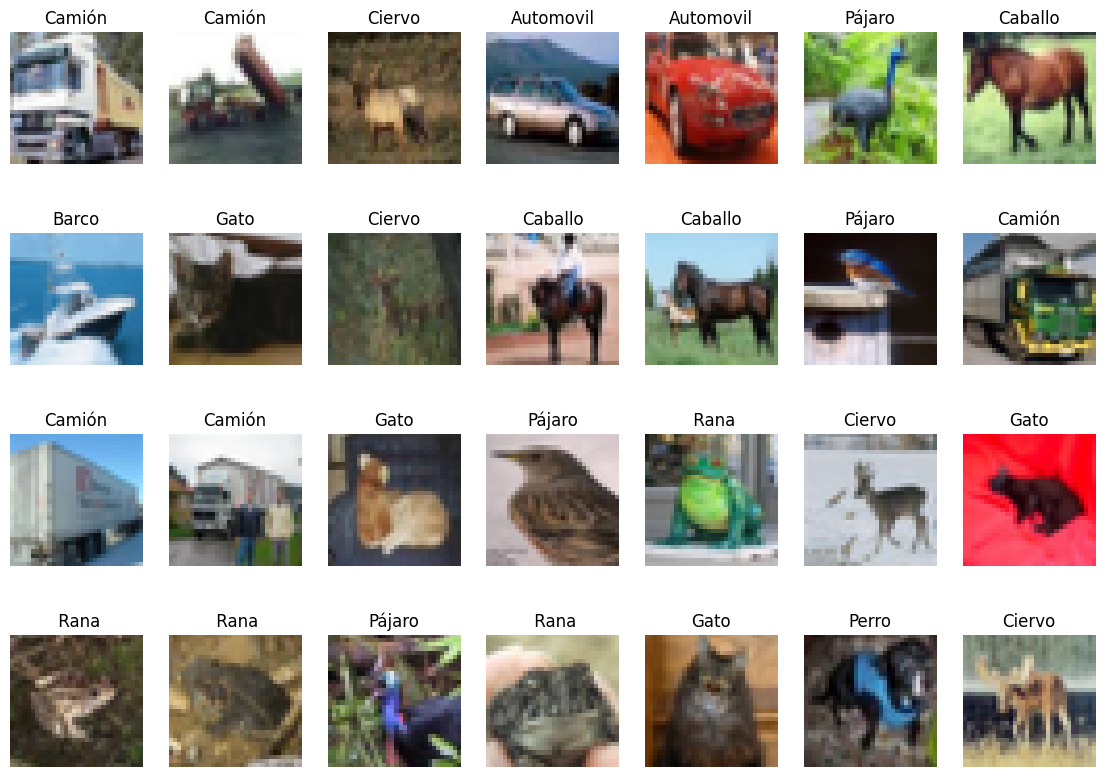

In [31]:
# Inspección del conjunto de datos

# Importante para el trabajo grupal!!! hacerlo. Evaluar frecuencia etiquetas, distribucion, balanceo...etc.

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14,10))

for n in range(1,29 ):
  fig.add_subplot(4,7,n)
  img = X_train[n]
  plt.imshow(img)
  plt.axis('off') # desactivar en el trabajo
  plt.title(labelNames[y_train[n][0]])

plt.show()

#### **- Creando la topología de red neuronal y entrenándola: MLP**

In [32]:
from tensorflow.keras import optimizers

# Arquitectura de red - modo API Sequential

mlp = Sequential()
mlp.add(layers.Flatten(input_shape=(32,32,3)))
mlp.add(layers.Dense(2048, activation='relu'))
mlp.add(layers.Dense(1024, activation='relu'))
mlp.add(layers.Dense(512, activation='relu'))
mlp.add(layers.Dense(256, activation='relu'))
mlp.add(layers.Dense(128, activation='relu'))
mlp.add(layers.Dense(10, activation='softmax')) # Capa salida

mlp.summary()

# Compilamos el modelo y entrenamos
mlp.compile(optimizer = optimizers.Adam(learning_rate=0.001),
               loss = 'sparse_categorical_crossentropy',
               metrics = ['accuracy']
                )

# Entrenamos el perceptrón multicapa
H = mlp.fit(X_train_n_tr, y_train_tr, epochs = 100, batch_size = 128,
                validation_data = (X_train_n_val, y_train_val))


# Learning curves
visualize_learning_curve(H)

# Evaluando el modelo de predicción con las imágenes de test
evaluate_model(mlp, X_test_n, y_test)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2048)           │     6,293,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,081,994 (34.65 MB)

 Trainable params: 9,081,994 (34.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


Exception ignored in: <function _xla_gc_callback at 0x79b6c0b8ccc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 


  5/352 ━━━━━━━━━━━━━━━━━━━━ 1:07 195ms/step - accuracy: 0.0795 - loss: 2.7742

KeyboardInterrupt: 

#### **- Creando la topología de red neuronal y entrenándola: CNN**

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 8, 8, 256)      │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,906,154 (11.09 MB)

 Trainable params: 2,906,154 (11.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.2980 - loss: 1.8785 - val_accuracy: 0.5414 - val_loss: 1.2661
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.5878 - loss: 1.1461 - val_accuracy: 0.6580 - val_loss: 0.9707
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.6957 - loss: 0.8631 - val_accuracy: 0.7230 - val_loss: 0.7942
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.7576 - loss: 0.6940 - val_accuracy: 0.7718 - val_loss: 0.6627
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.8070 - loss: 0.5564 - val_accuracy: 0.7722 - val_loss: 0.6772
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.8520 - loss: 0.4263 - val_accuracy: 0.7712 - val_loss: 0.6592
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.8845 - loss: 0.3302 - val_accuracy: 0.7806 - val_loss: 0.6814
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9141 - loss: 0.2435 - val

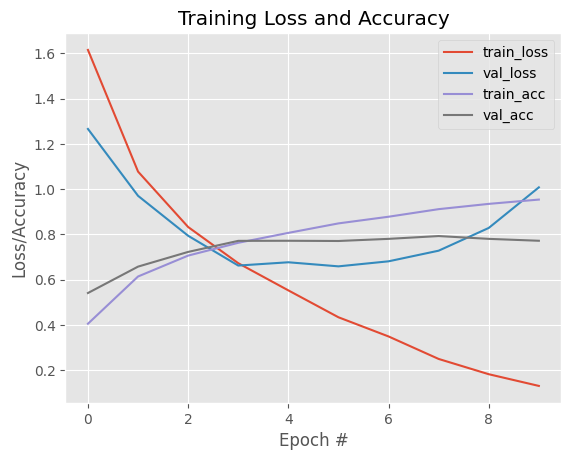

In [31]:
# Arquitectura de red - modo API Functional

# (Iremos concatenando la salida de un bloqueo con la del otro)

from tensorflow.keras.models import Model

# Capa de entrada
input = layers.Input(shape=(32,32,3))

#-----------------#
# 1.BASE MODEL
#-----------------#

# Bloque 1
x1 = layers.Conv2D(32, (3,3), padding='same', activation='relu')(input)
x1 = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x1)
x1 = layers.MaxPooling2D((2,2))(x1)

# Bloque 2
x2 = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x1)
x2 = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x2)
x2 = layers.MaxPooling2D((2,2))(x2)

# Bloque 3
x3 = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x2)
x3 = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x3)
x3 = layers.MaxPooling2D((2,2))(x3)


#-----------------#
# 2.TOP MODEL
#-----------------#
xfc = layers.Flatten()(x3)
xfc = layers.Dense(512, activation='relu')(xfc)
predictions = layers.Dense(10, activation='softmax')(xfc)

# Hoy en dia ya no se suelen usar capas densas en el TOP model ya que introducen muchos parámetros
# Normalmente nos quedamos con promedios espaciales para eliminar nº atributos en lugar de Flatten + Dense

# Tendencias actuales:
#xfc = layers.GlobalMaxPooling2D()(x3)
#predictions=layers.Dense(10, activation='softmax')(xfc)   # Pasamos a tener 3 veces menos parámetros (de casi 3 millones a unos 800 mil)

#---------------------------------------------#
# 3. Unimos las entradas y salidas del modelo
#---------------------------------------------#
convnet = Model(inputs=input, outputs=predictions)
convnet.summary()

# Compilamos el modelo y entrenamos
convnet.compile(optimizer = optimizers.Adam(learning_rate=0.001),
               loss = 'sparse_categorical_crossentropy',
               metrics = ['accuracy']
                )

# Entrenamos el perceptrón multicapa
H = convnet.fit(X_train_n_tr, y_train_tr, epochs = 10, batch_size = 128,
                validation_data = (X_train_n_val, y_train_val))

# Learning curves
visualize_learning_curve(H)

# Evaluando el modelo de predicción con las imágenes de test
evaluate_model(convnet, X_test_n, y_test)

# Almaceno el modelo en Drive

## Batch normalization y Drop out

Añadimos capas al codigo anterior para evitar gradientes explosivos (bathc normalization) y drop-out para reducir el sobre-ajuste

In [33]:
# Arquitectura de red - modo API Functional

# (Iremos concatenando la salida de un bloqueo con la del otro)

from tensorflow.keras.models import Model

# Capa de entrada
input = layers.Input(shape=(32,32,3))

#-----------------#
# 1.BASE MODEL
#-----------------#

# Bloque 1
x1 = layers.Conv2D(32, (3,3), padding='same', activation='relu')(input)
x1 = layers.BatchNormalization()(x1)  # Capa de batch normalization. Siempre después de la capa conv o fully connected activada con rleu
x1 = layers.Dropout(0.1)(x1) # drop-out para cancelar activacion algunas neuronas y reducir sobre-ajuste
x1 = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Dropout(0.1)(x1)
x1 = layers.MaxPooling2D((2,2))(x1)

# Bloque 2
x2 = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x1)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Dropout(0.1)(x2)
x2 = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x2)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Dropout(0.1)(x2)
x2 = layers.MaxPooling2D((2,2))(x2)

# Bloque 3
x3 = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x2)
x3 = layers.BatchNormalization()(x3)
x3 = layers.Dropout(0.1)(x3)
x3 = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x3)
x3 = layers.BatchNormalization()(x3)
x3 = layers.Dropout(0.1)(x3)
x3 = layers.MaxPooling2D((2,2))(x3)


#-----------------#
# 2.TOP MODEL
#-----------------#
#xfc = layers.Flatten()(x3)
#xfc = layers.Dense(512, activation='relu')(xfc)
#predictions = layers.Dense(10, activation='softmax')(xfc)

# Hoy en dia ya no se suelen usar capas densas en el TOP model ya que introducen muchos parámetros
# Normalmente nos quedamos con promedios espaciales para eliminar nº atributos en lugar de Flatten + Dense

# Tendencias actuales:
xfc = layers.GlobalMaxPooling2D()(x3)
predictions=layers.Dense(10, activation='softmax')(xfc)   # Pasamos a tener 3 veces menos parámetros (de casi 3 millones a unos 800 mil)

#---------------------------------------------#
# 3. Unimos las entradas y salidas del modelo
#---------------------------------------------#
convnet = Model(inputs=input, outputs=predictions)
convnet.summary()

# Compilamos el modelo y entrenamos
convnet.compile(optimizer = optimizers.Adam(learning_rate=0.001),
               loss = 'sparse_categorical_crossentropy',
               metrics = ['accuracy']
                )

# Entrenamos el perceptrón multicapa
H = convnet.fit(X_train_n_tr, y_train_tr, epochs = 20, batch_size = 128,
                validation_data = (X_train_n_val, y_train_val))

# Learning curves
visualize_learning_curve(H)

# Evaluando el modelo de predicción con las imágenes de test
evaluate_model(convnet, X_test_n, y_test)

# Almaceno el modelo en Drive

Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 8, 8, 256)      │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 4, 4, 256)      │             

 Total params: 808,746 (3.09 MB)

 Trainable params: 807,338 (3.08 MB)

 Non-trainable params: 1,408 (5.50 KB)

Epoch 1/20


KeyboardInterrupt: 

## **REDUCIENDO OVERFITTING MEDIANTE DATA AUGMENTATION**

#### **- Acondicionando dataset**

In [34]:
# Binarizar etiquetas - por si es necesario convertir a one-hot encoding
from sklearn.preprocessing import LabelBinarizer

# Instanciamos el método y lo aplicamos
lb = LabelBinarizer()
y_train_tr_ohe = lb.fit_transform(y_train_tr)
y_train_val_ohe = lb.fit_transform(y_train_val)
y_test_ohe = lb.fit_transform(y_test)

print(y_train_val_ohe.shape)
print(y_train_val_ohe[:10, :])

(5000, 10)
[[0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]]


#### **- Creando un contenedor DataGenerator para el aumento automático de muestras**

In [35]:
# Crear Image DataGenerator

# Coge un conjunto reducido de imagenes del bach y las transforma y las envia al modelo
# Además de servir para aumentar muestras, también sirve para cargarlas online (por problemas de memoria) y solo carga las que usa en el bach en ese momento

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.20,
    height_shift_range = 0.20,
    horizontal_flip = True,
    zoom_range = 0.1,
    #rescale = 1/255.
)

# Cuidado si empleamos rescale en el ImageDataGenerator,
#no debemos emplearlo previamente. Además, al testear, si no empleamos el ImageDataGen,
# podemos tener resultados incorrectos (deberiamos crear otro datagen_test)

# CUIDADO! shuffle por defecto en flow está en True. CUIDADO EN TEST!
# si usamos: predictions = model.predict(datagen_val.flow(x_test, batch_size=128, shuffle = False))
# puede que la etiqueta de predict sea distinta, por lo tanto al calcular la métrica estaremos comparando muestras distintas ya que se han barajado
# si lo empleamos para test, hay que ponerlo en FALSE

#### **- Inspeccionando las muestras generadas sintéticamente**

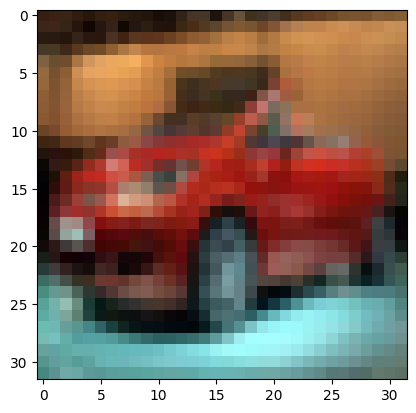

Label = Avión


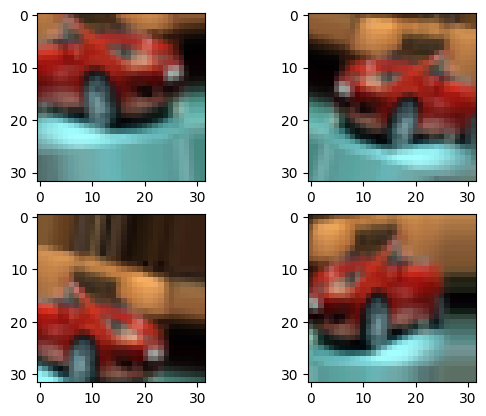

In [19]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

sample = 45
plt.imshow(image.array_to_img(X_train[sample]))
plt.show()
print('Label = {}'.format(labelNames[y_train[sample].argmax(axis=0)]))

fig, axes = plt.subplots(2,2)
i = 0
for batch in datagen.flow(X_train[sample].reshape((1,32,32,3)),batch_size=1):
    #plt.figure(i)
    axes[i//2,i%2].imshow(image.array_to_img(batch[0]))
    i += 1
    if i == 4:
        break
plt.show()

#### **- Creando la topología de red neuronal y entrenándola: CNN**

In [37]:
# Arquitectura de red - modo API Functional

# (Iremos concatenando la salida de un bloqueo con la del otro)

from tensorflow.keras.models import Model

# Capa de entrada
input = layers.Input(shape=(32,32,3))

#-----------------#
# 1.BASE MODEL
#-----------------#

# Bloque 1
x1 = layers.Conv2D(32, (3,3), padding='same', activation='relu')(input)
x1 = layers.BatchNormalization()(x1)  # Capa de batch normalization. Siempre después de la capa conv o fully connected activada con rleu
x1 = layers.Dropout(0.1)(x1) # drop-out para cancelar activacion algunas neuronas y reducir sobre-ajuste
x1 = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Dropout(0.1)(x1)
x1 = layers.MaxPooling2D((2,2))(x1)

# Bloque 2
x2 = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x1)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Dropout(0.1)(x2)
x2 = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x2)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Dropout(0.1)(x2)
x2 = layers.MaxPooling2D((2,2))(x2)

# Bloque 3
x3 = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x2)
x3 = layers.BatchNormalization()(x3)
x3 = layers.Dropout(0.1)(x3)
x3 = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x3)
x3 = layers.BatchNormalization()(x3)
x3 = layers.Dropout(0.1)(x3)
x3 = layers.MaxPooling2D((2,2))(x3)


#-----------------#
# 2.TOP MODEL
#-----------------#
#xfc = layers.Flatten()(x3)
#xfc = layers.Dense(512, activation='relu')(xfc)
#predictions = layers.Dense(10, activation='softmax')(xfc)

# Hoy en dia ya no se suelen usar capas densas en el TOP model ya que introducen muchos parámetros
# Normalmente nos quedamos con promedios espaciales para eliminar nº atributos en lugar de Flatten + Dense

# Tendencias actuales:
xfc = layers.GlobalMaxPooling2D()(x3)
predictions=layers.Dense(10, activation='softmax')(xfc)   # Pasamos a tener 3 veces menos parámetros (de casi 3 millones a unos 800 mil)

#---------------------------------------------#
# 3. Unimos las entradas y salidas del modelo
#---------------------------------------------#
convnet = Model(inputs=input, outputs=predictions)
convnet.summary()

# Compilamos el modelo y entrenamos
convnet.compile(optimizer = optimizers.Adam(learning_rate=0.001),
               loss = 'categorical_crossentropy',
               metrics = ['accuracy']
                )

# Entrenamos el perceptrón multicapa
batch_size = 128
H = convnet.fit(datagen.flow(X_train_n_tr, y_train_tr_ohe, batch_size = batch_size),  # Importante, existe shuffle = True (por defecto los baraja, cuidado! al predecir pueden ser distintos indices si lo hacemos así: predictions = model.predict(datagen_val.flow(...)))
                epochs = 40,
                steps_per_epoch = X_train_n_tr.shape[0] // batch_size ,
                validation_data = (X_train_n_val, y_train_val_ohe)
)

# Learning curves
visualize_learning_curve(H)

# Evaluando el modelo de predicción con las imágenes de test
evaluate_model(convnet, X_test_n, y_test)

# Almaceno el modelo en Drive
convnet.save("convnet_augmentation_CIFAR10_h5")

Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 8, 8, 256)      │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 4, 4, 256)      │             

 Total params: 808,746 (3.09 MB)

 Trainable params: 807,338 (3.08 MB)

 Non-trainable params: 1,408 (5.50 KB)

Epoch 1/40


KeyboardInterrupt: 

**EJERCICIO PROPUESTO:** Modificar la ejecución con Data Augmentation para que sea directamente comparable a la ejecución por defecto. Para ello, el validation data debe ser correcto. Pista: Llevar a cabo el validation split cuando se instancia el objeto ImageDataGenerator. El método flow también se verá afectado (leer documentación).

## **TRABAJANDO CON REDES PRE-ENTRENADAS: TRANSFER LEARNING & FINE-TUNING**


#### **- Cargando el conjunto de datos y acondicionándolo como en la VGG**

In [3]:
# Imports necesarios

# Importando y normalizando el set de datos CIFAR10

# One-hot encoding

# IMPORTANTE: Se normalizan los datos como se normalizaron en el entrenamiento con ImageNet!!


#### **- Cargando la topología de CNN (base model)**

In [4]:
# keras incluye varias arquitecturas
# VGG16, VGG19, ResNet50, Xception, InceptionV3, InceptionResNetV2, MobileNetV2, DenseNet, RasNet
# documentacion https://keras.io/applications/
# Visual Geometry Group 16 / 19 (numero de layers)
# 1 y 2 en la competicion ImageNet 2014
# Kernels pequeños de 3x3

# Cargar arquitectura y pesos
from tensorflow.keras.applications import ResNet50, EfficientNetB0, VGG16

base_model = ResNet50(weights = 'imagenet', include_top = False,
                      input_shape = (32, 32, 3)
)

base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 16, 16,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 16, 16,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 8, 8, 256) │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 8, 8, 256) │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

#### **- Creando el top model y congelando TODAS las capas convolucionales (TRANSFER LEARNING)**

In [6]:
# Conectar el modelo con el top model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

# No entrenamos el base model
base_model.trainable = False

pre_trained_model = Sequential()
pre_trained_model.add(layers.Input(shape=(32,32,3)))
pre_trained_model.add(base_model)
pre_trained_model.add(layers.GlobalMaxPooling2D())
pre_trained_model.add(layers.Dense(10, activation='softmax'))
pre_trained_model.summary()

# Compilamos el modelo y entrenamos
pre_trained_model.compile(optimizer = optimizers.Adam(learning_rate=0.001),
               loss = 'categorical_crossentropy',
               metrics = ['accuracy']
                )

# Entrenamos el perceptrón multicapa
batch_size = 128
H = pre_trained_model.fit(datagen.flow(X_train_n_tr, y_train_tr_ohe, batch_size = batch_size),  # Importante, existe shuffle = True (por defecto los baraja, cuidado! al predecir pueden ser distintos indices si lo hacemos así: predictions = model.predict(datagen_val.flow(...)))
                epochs = 40,
                steps_per_epoch = X_train_n_tr.shape[0] // batch_size ,
                validation_data = (X_train_n_val, y_train_val_ohe)
)

# Learning curves
visualize_learning_curve(H)

# Evaluando el modelo de predicción con las imágenes de test
evaluate_model(convpre_trained_modelnet, X_test_n, y_test)

# pre_trained_model el modelo en Drive
convnet.save("pre_trained_model_augmentation_CIFAR10_h5")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 1, 1, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_1          │ (None, 2048)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

NameError: name 'optimizers' is not defined

#### **- Entrenando la solución**

In [ ]:
# Import the necessary packages

# Compilamos el modelo y entrenamos

# Entrenamos el perceptrón multicapa

# Learning curves
visualize_learning_curve(...)

# Evaluando el modelo de predicción con las imágenes de test
evaluate_model(...)

# Almaceno el modelo en Drive

#### **- Creando el top model y descongelando bloques convolucionales (FINE TUNING)**

In [ ]:
# Fine-tuning completo
base_model.trainable = True

pre_trained_model = Sequential()
pre_trained_model.add(layers.Input(shape=(32,32,3)))
pre_trained_model.add(base_model)
pre_trained_model.add(layers.GlobalMaxPooling2D())
pre_trained_model.add(layers.Dense(10, activation='softmax'))
pre_trained_model.summary()


# Fine-tuning parcial: capa a capa, por e.g., congelamos hasta bloque 4
for layer in base_model.layers:
  if layer.name=='conv5_block1_1_conv':
    break
  else:
    layer.trainable = False
    print('Capa '+ layer.name + ' congelada')


pre_trained_model = Sequential()
pre_trained_model.add(layers.Input(shape=(32,32,3)))
pre_trained_model.add(base_model)
pre_trained_model.add(layers.GlobalMaxPooling2D())
pre_trained_model.add(layers.Dense(10, activation='softmax'))
pre_trained_model.summary()

# En caso de inestabilidades numéricas pasar datos a one-hot encoding

# Importamos VGG16 con pesos de imagenet y sin top_model especificando tamaño de entrada de datos

# Mostramos la arquitectura

# Congelamos las capas de los 4 primeros bloques convolucionales, el quinto se re-entrena
# En base_model.layers.name tenemos la información del nombre de la capa

# Cogemos la última capa del model y le añadimos nuestro clasificador (top_model)

# Compilamos el modelo y entrenamos

# Entrenamos el perceptrón multicapa

# Learning curves
visualize_learning_curve(...)

# Evaluando el modelo de predicción con las imágenes de test
evaluate_model(...)

# Almaceno el modelo en Drive

**EJERCICIO PROPUESTO:** Combinar fine tuning con la técnica de data augmentation para reducir overfitting.

## **VISUALIZANDO POR DENTRO UNA CNN**

#### **- Visualizar activaciones intermedias**

- Visualizar el output de las capas de la red
- 2D imagen por canal

In [ ]:
%tensorflow_version 1.x
from tensorflow.keras.datasets import cifar10
from sklearn.preprocessing import LabelBinarizer

# Importando y normalizando el set de datos CIFAR10
print("[INFO]: Loading CIFAR-10 data...")
((trainX, trainY), (testX, testY)) = cifar10.load_data()
labelNames = ["Avión", "Automóvil", "Pájaro", "Gato", "Ciervo", "Perro", "Rana", "Caballo", "Barco", "Camión"]

#One-hot encoding
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

In [ ]:
from keras.models import load_model
model_augmentation = load_model(BASE_FOLDER+'resources/convnet_augmentation.h5')
model_augmentation.summary()

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import array_to_img
%matplotlib inline

# Visualizando imagen
sample = 1000
input_img = trainX[sample].reshape((1,32,32,3))
plt.imshow(array_to_img(trainX[sample]))
plt.show()

In [ ]:
# Modificar el modelo para que nos devuelva los mapas de activación


In [ ]:
# Visualización de la salida de un filtro - activacion, 32 canales, feature map de 30x30


In [ ]:
# Visualización de las activaciones en todas las capas



### Interpretacion
- Capas iniciales son como detectores de bordes
- Capas más profundas son más difíciles de interpretar (abstractas) y tienen información relativa a la clase de imagen
- La activación de capas profundas es más dispersa (sparse)

#### **- Visualizar filtros convolucionales**

- Visualizar las imagenes que maximizan la respuesta a un filtro

In [ ]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',include_top=False)
model.summary()

In [ ]:
import numpy as np

def gen_max_response_pattern(layer_name, filter_index, size=32):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])

    # Para obtener el patron que responde de forma máxima, utilizamos descenso del gradiente
    grads = K.gradients(loss,model.input)[0] # Seleccionar el primero, ya que esto devuelve una lista
    # Normalización para ayudar al proceso del gradiente
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5) # Última constante para evitar dividir por 0
    # Definir funcion que calcula la pérdida y el gradiente de la imagen
    iterate = K.function([model.input], [loss,grads])
    loss_value, grads_value = iterate([np.zeros((1,size,size,3))])

    # Iniciamos con imagen aleatoria
    input_img_data = np.random.random((1,size,size,3)) * 20 + 128

    step = 1. # Magnitud de cada actualizacion en el gradiente
    n_steps = 40 # Número de iteraciones
    for i in range(n_steps):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    img = input_img_data[0]
    # Procesar la imagen resultante
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.1
    img += 0.5
    img = np.clip(img,0,1)
    img *= 255
    img = np.clip(img,0,255).astype('uint8')

    return img

In [ ]:
# mostrar un patron para un filtro
import matplotlib.pyplot as plt
%matplotlib inline

layer_name = 'block2_conv1'
filter_index = 112 # canal a estudiar

img = gen_max_response_pattern(layer_name,filter_index,32)
plt.imshow(img)

**EJERCICIO PROPUESTO:** Mostrar los patrones de maxima activacion para todos los filtros de una capa.

#### **- Visualizar hetmaps de activación por clase**

- Útil para averiguar qué partes de la imagen contribuyen más a la decisión
- Interesante para saber qué pasa cuando se cometen errores

In [ ]:
# Técnica utiliza gradientes Ramprasaath, R. Selvaraju et al. (2017). https://arxiv.org/abs/1610.02391
from keras.applications import VGG16

model = VGG16(weights='imagenet',include_top=True)

In [ ]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

# Cargar imagen de gato
img = image.load_img(BASE_FOLDER+'resources/cat.jpg', target_size=(224,224))
x = image.img_to_array(img) # a array de (224,224,3)
x = np.expand_dims(x, axis=0) # a array de (1,224,224,3)
x = preprocess_input(x)

In [ ]:
# Testeando el output
prediction = model.predict(x)
print(decode_predictions(prediction))

In [ ]:
tabby_output_index = np.argmax(prediction[0])
tabby_output = model.output[:,tabby_output_index]
last_conv_layer = model.get_layer('block5_conv3')

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from keras import backend as K

grads = K.gradients(tabby_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0,1,2))
iterate = K.function( [model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

# Multiplicar cada canal en el feature map por como de importante el canal es con respecto a la clase "tabby"
for i in range(512):
    conv_layer_output_value[:,:,i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)

# Visualizar
heatmap = np.maximum(heatmap,0)
heatmap /= np.max(heatmap)
fig,axes = plt.subplots(1,2)
axes[0].matshow(heatmap)
axes[1].imshow(img)
plt.show()

**EJERCICIO PROPUESTO:** Obtener el heatmap para las otras clases en la lista de prediccion (Egyptian_cat, tiger_cat, etc.).